In [1]:
import os
import pandas as pd
import py3Dmol
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from metfish.utils import get_Pr

from prody import *

In [2]:
apo_holo_dir = "/global/cfs/cdirs/m3513/metfish/apo_holo_data"
test_data_df = pd.read_csv(f"{apo_holo_dir}/input_no_training_data.csv")
names = test_data_df['name'].to_list()

In [3]:
name = names[0]
fname = f"{apo_holo_dir}/pdbs/{name}_atom_only.pdb"
n_modes = 10
n_confs = 20

# select alpha carbons
structure = parsePDB(fname)
calphas = structure.select('calpha')

# perform normal mode analysis
anm = ANM('ANM analysis')
anm.buildHessian(calphas)  # default values are cutoff=15.0 and gamma=1.0
anm.calcModes(n_modes=n_modes)

# write nmd file"
writeNMD('structure_anm_modes.nmd', anm, calphas)

@> 2114 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Hessian was built in 0.06s.
@> 10 modes were calculated in 0.01s.


'structure_anm_modes.nmd'

In [4]:
# view protein
# showProtein(calphas,
#             vecs=anm[0].getArray(),
#             flucts=calcSqFlucts(anm[0]),
#             style={'cartoon':{}})

In [5]:
# view modes
# VMD.setPath()
# viewNMDinVMD('structure_anm_modes.nmd')

In [6]:
rmsd = len(calphas) * 0.02
rmsd
# for 1AEL-12, 2NLN, getting the rmsd as 1.5-2.5% of the calphas seems like a good range
# overall i think an rmsd of 2-3 is a good range

2.62

@> Parameter: rmsd = 5.00 A
@> Parameter: n_steps = 10
@> Step size is 0.50 A RMSD
@> Mode is scaled by 30.54054567847533.


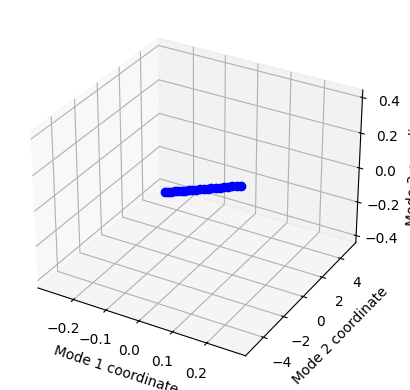

In [7]:
# extend the model
anm_ext, _ = extendModel(anm, calphas, structure, norm=True)

# sample conformations along the ANM nodes
#ens = sampleModes(anm_ext, atoms=structure, n_confs=n_confs, rmsd=2)
ens = traverseMode(anm_ext[1], atoms=structure, n_steps=n_confs/2, rmsd=5)

# show projections
showProjection(ens, anm_ext[:3], rmsd=True);

In [8]:
# write confirmations
structure.addCoordset(ens.getCoordsets())
structure.all.setBetas(0)
structure.ca.setBetas(1)

for i in range(1, structure.numCoordsets()):  # skipping 0th coordinate set
    fn = os.path.join('structure_ensemble', f'{name}_{i}.pdb')
    writePDB(fn, structure, csets=i)

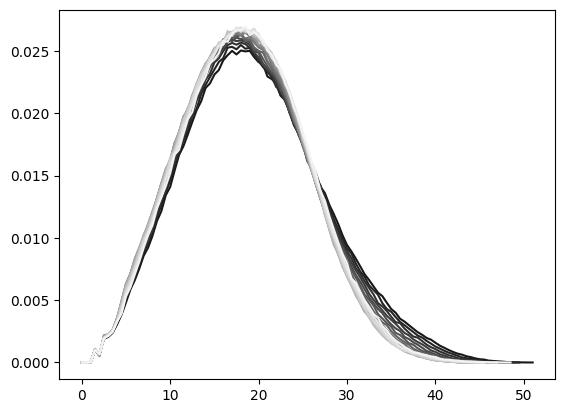

In [9]:
# calculate and plot saxs curves
palette = [mcolors.to_hex(c) for c in sns.color_palette('grey', n_colors=n_confs)]

fig, ax = plt.subplots(1, 1)
for i in range(1, n_confs):
    fn = os.path.join('structure_ensemble', f'{name}_{i}.pdb')
    r, p = get_Pr(fn, name, None, 0.5)
    
    ax.plot(r, p, color=palette[i])


In [10]:
# visualize conformations

view = py3Dmol.view(width='300', viewergrid=(1, 2))
# compare different models
for i in range(1, n_confs):
    fn = os.path.join('structure_ensemble', f'{name}_{i}.pdb')
    view.addModel(open(fn, 'r').read(), 'pdb', viewer=(0, 0))
    view.setStyle({'model': i-1}, {"cartoon": {'color': palette[i]}}, viewer=(0, 0))

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
for i in anm_ext:
    print(i)

Mode 1 from NMA Extended ANM ANM analysis
Mode 2 from NMA Extended ANM ANM analysis
Mode 3 from NMA Extended ANM ANM analysis
Mode 4 from NMA Extended ANM ANM analysis
Mode 5 from NMA Extended ANM ANM analysis
Mode 6 from NMA Extended ANM ANM analysis
Mode 7 from NMA Extended ANM ANM analysis
Mode 8 from NMA Extended ANM ANM analysis
Mode 9 from NMA Extended ANM ANM analysis
Mode 10 from NMA Extended ANM ANM analysis
